In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.graph_objects as go
import snscrape.modules.twitter as sntwitter
from tqdm.notebook import tqdm

In [3]:
%load_ext lab_black

In [3]:
msft = yf.Ticker("MSFT")

In [4]:
hist = msft.history(period="max")

<AxesSubplot: xlabel='Date'>

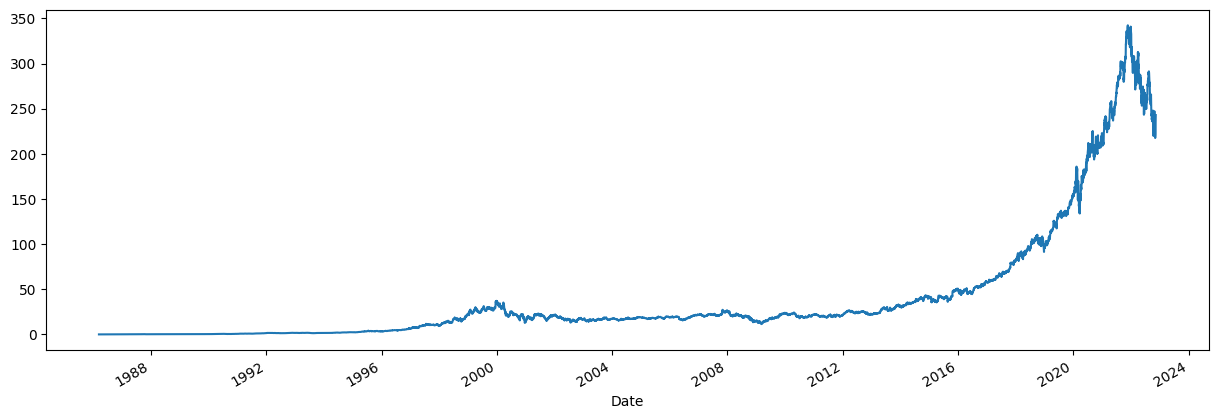

In [5]:
hist["Open"].plot(figsize=(15, 5))

In [6]:
msft.calendar

0                    1
Earnings Date     2023-01-23 10:59:00  2023-01-27 12:00:00
Earnings Average                 2.29                 2.29
Earnings Low                     2.23                 2.23
Earnings High                    2.36                 2.36
Revenue Average           52969300000          52969300000
Revenue Low               52389000000          52389000000
Revenue High              53475000000          53475000000

## Pick a bunch of stocks

In [34]:
stocks = [
    "ETSY",
    "PINS",
    "SQ",
    "SHOP",
    "O",
    "MELI",
    "ISRG",
    "DIS",
    "BRK-B",
    "AMZN",
]

In [35]:
hists = {}
for s in stocks:
    tkr = yf.Ticker(s)
    history = tkr.history(period="3y")
    hists[s] = history

### Plot the stock plot

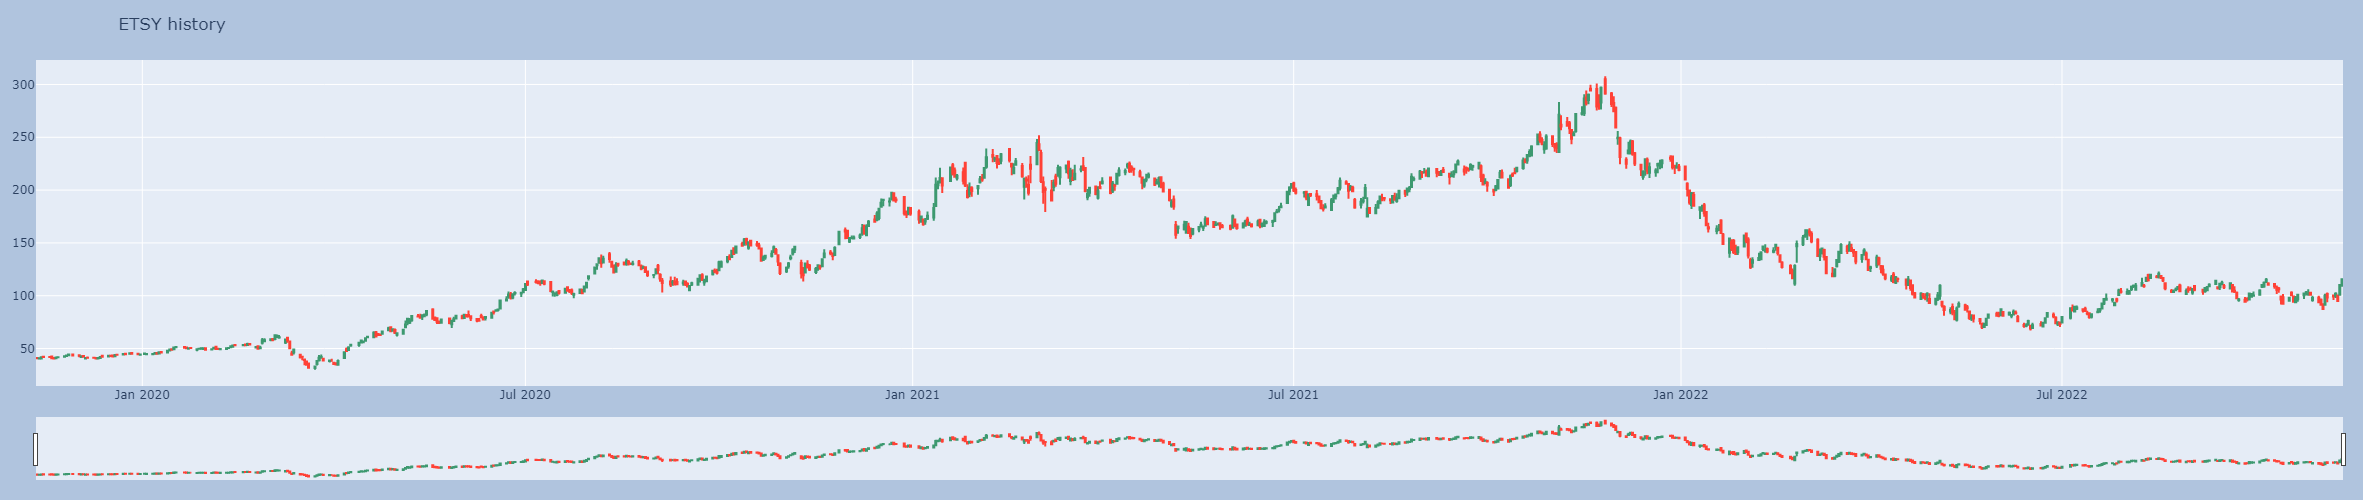

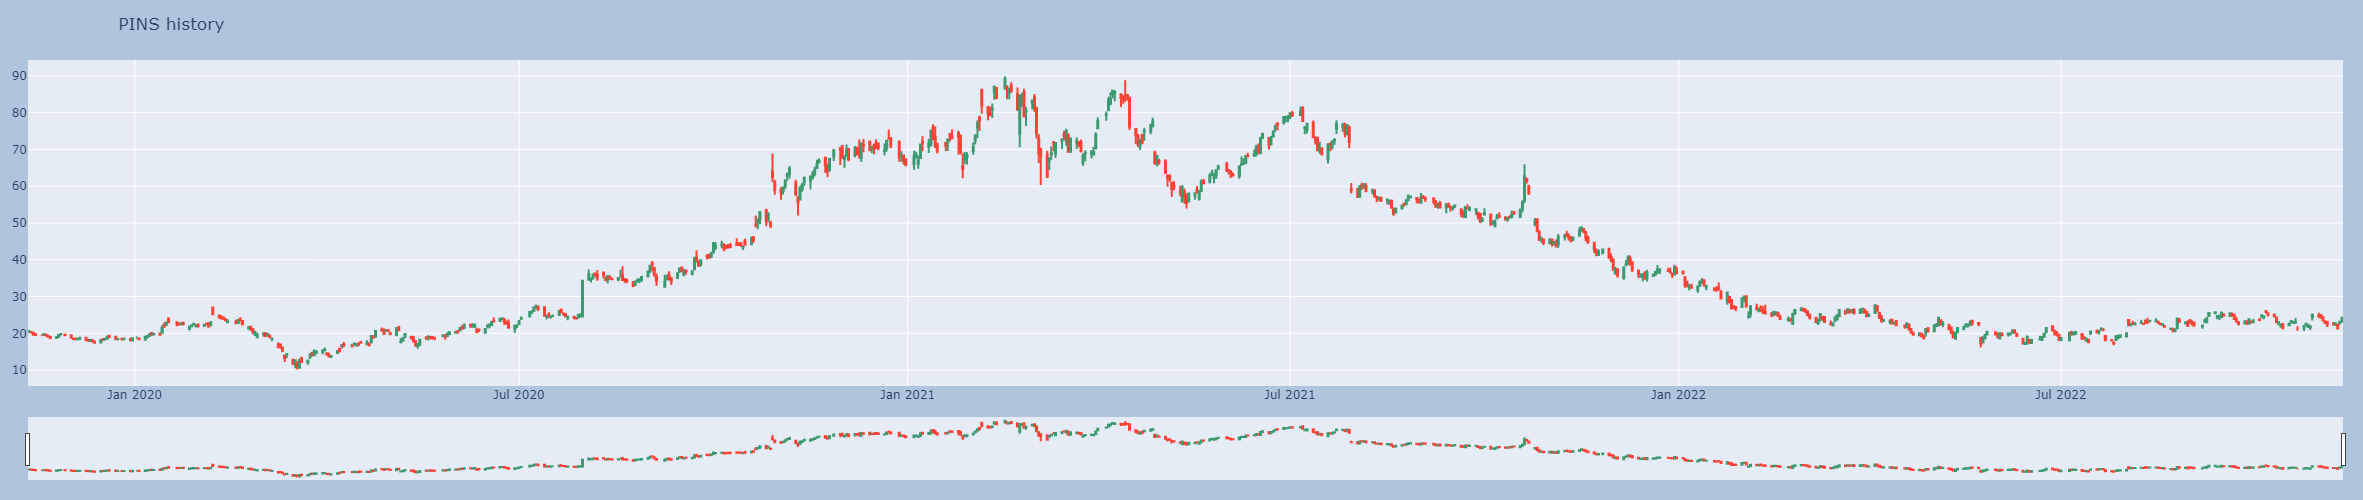

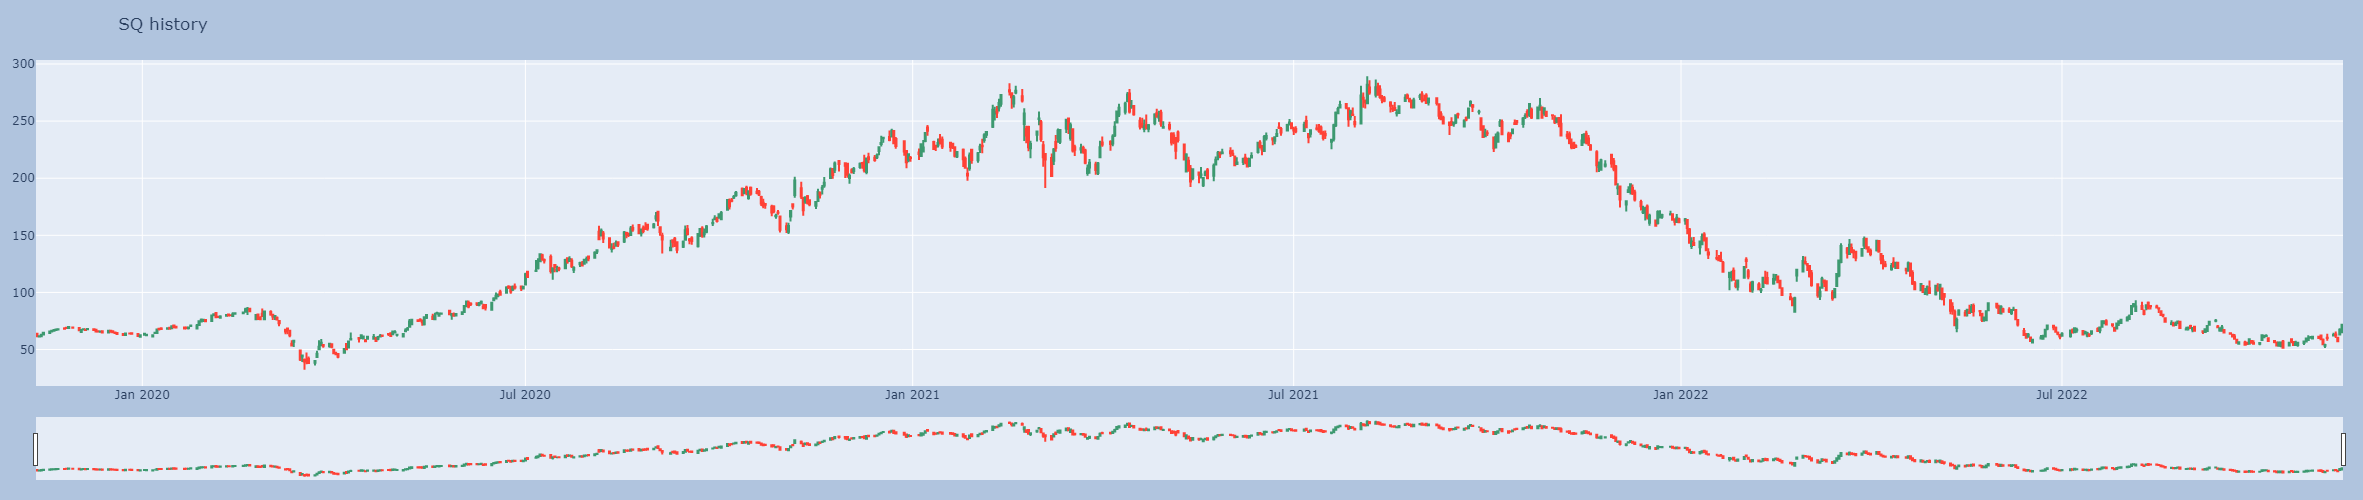

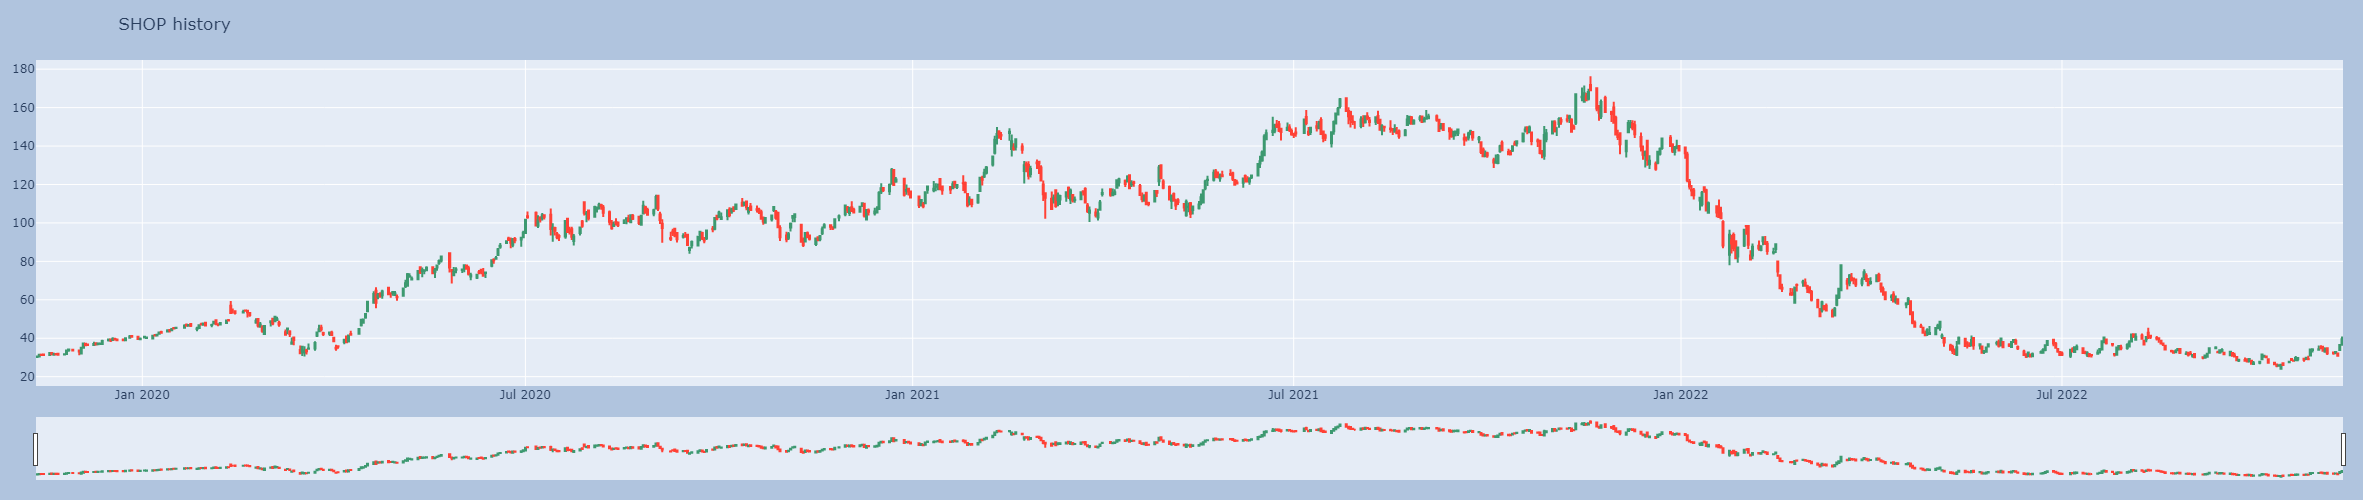

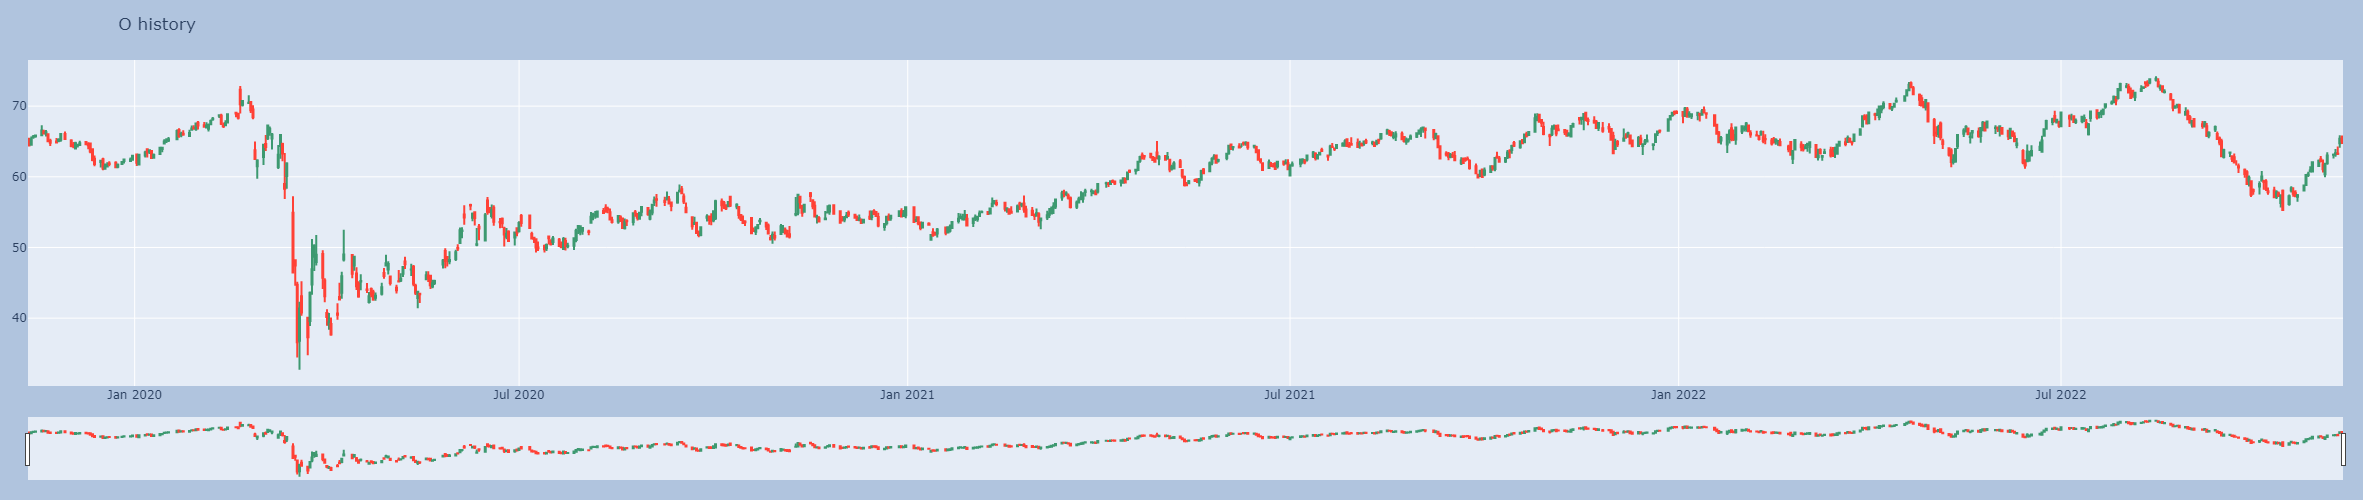

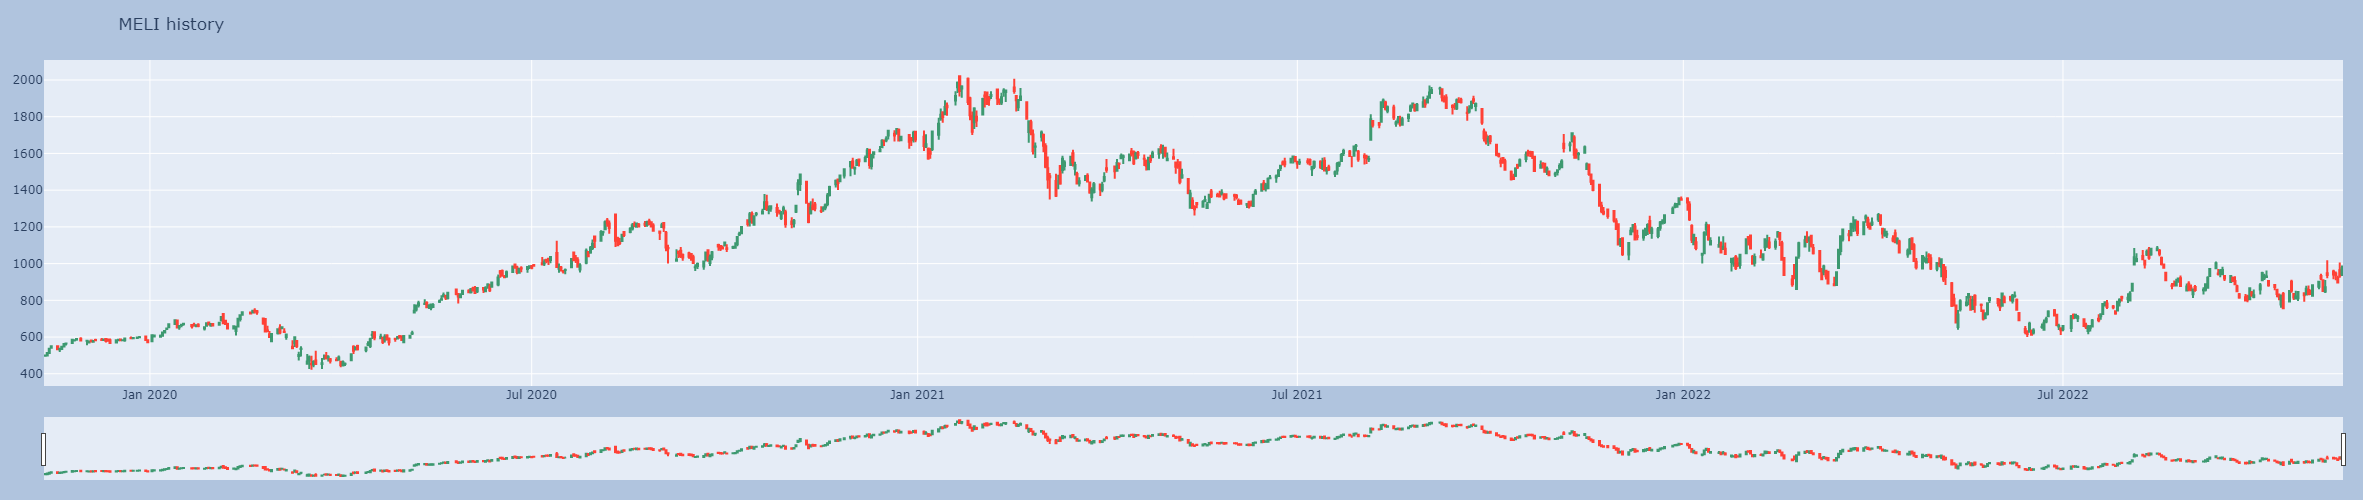

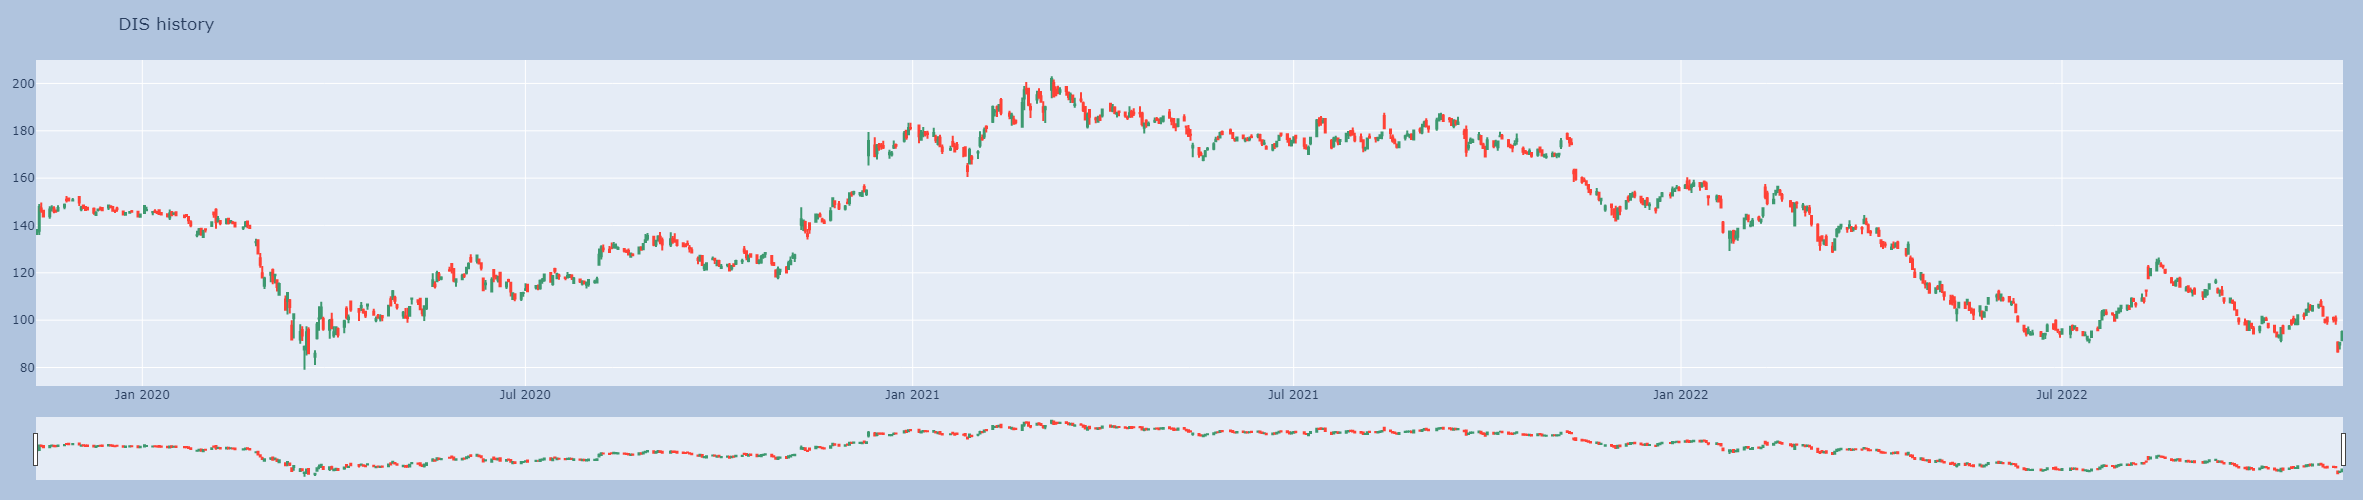

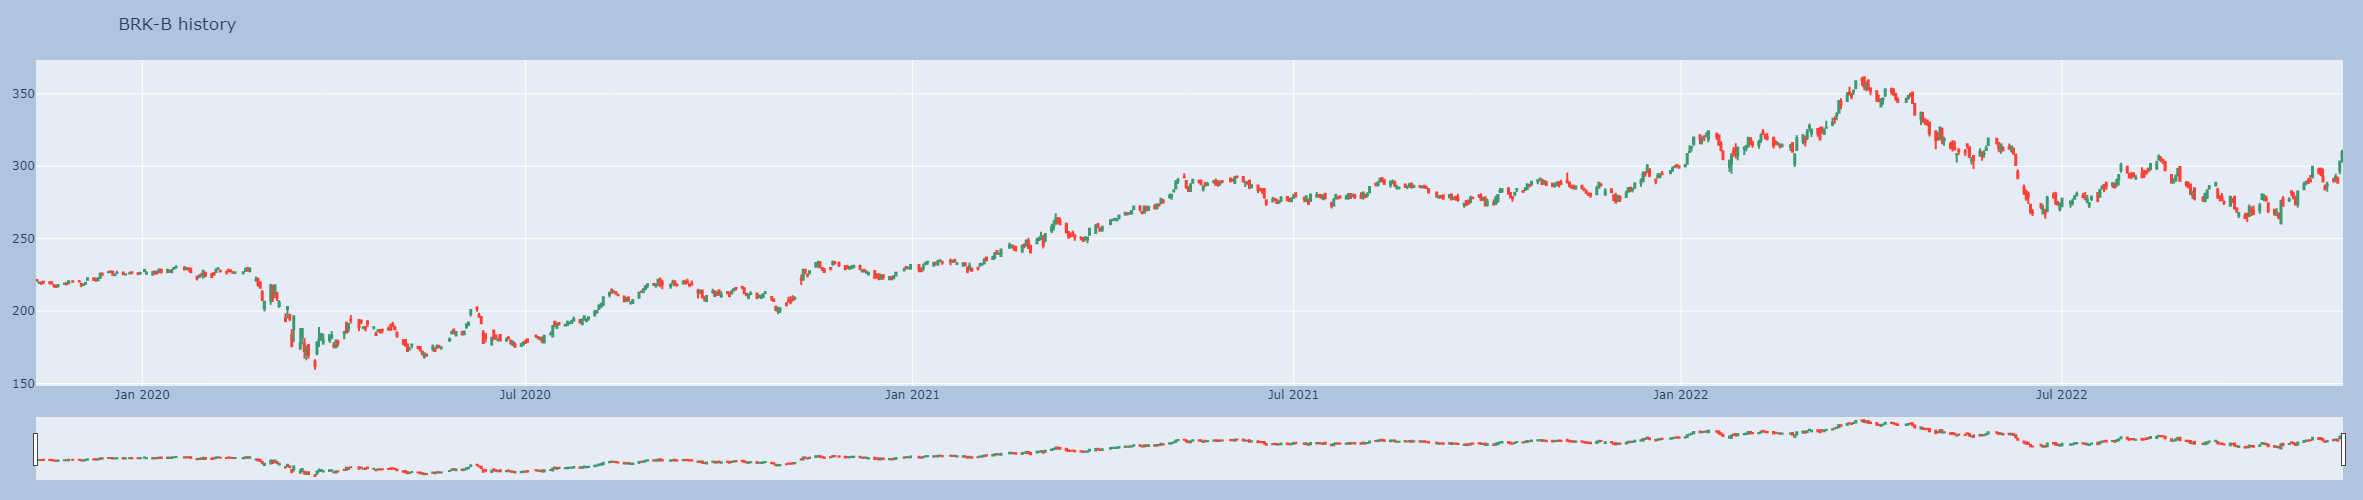

In [9]:
for stock in stocks:
    temp_df = hists[stock].copy()
    fig = go.Figure(
        data=[
            go.Candlestick(
                x=temp_df.index,
                open=temp_df["Open"],
                high=temp_df["High"],
                low=temp_df["Low"],
                close=temp_df["Close"],
            )
        ]
    )

    fig.update_layout(
        margin=dict(l=20, r=20, t=60, b=20),
        height=500,
        paper_bgcolor="LightSteelBlue",
        title=f"{stock} history",
    )

    fig.show()

In [10]:
hists["AMZN"].index.min()

Timestamp('2019-11-12 00:00:00-0500', tz='America/New_York')

In [11]:
stock = "AMZN"

In [12]:
!jupyter nbextension enable --py widgetsnbextension
from ipywidgets import FloatProgress

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


## Scrape Twitter

In [13]:
# Creating list to append tweet data
tweets_list = []
# Using TwitterSearchScraper to scrape data and append tweets to list
for i, tweet in tqdm(
    enumerate(
        sntwitter.TwitterSearchScraper(
            f"${stock} since:2019-11-12 until:2022-11-12"
        ).get_items()
    ),
    total=12_000,
):  # declare a username
    if i > 12_000:  # number of tweets you want to scrape
        break
    tweets_list.append(
        [tweet.date, tweet.id, tweet.content, tweet.user.username]
    )  # declare the attributes to be returned
# Creating a dataframe from the tweets list above
tweet_df = pd.DataFrame(
    tweets_list, columns=["Datetime", "Tweet Id", "Text", "Username"]
)

  0%|          | 0/12000 [00:00<?, ?it/s]

In [14]:
tweet_df.describe()

Tweet Id
count  1.200100e+04
mean   1.590364e+18
std    5.282429e+14
min    1.589368e+18
25%    1.589964e+18
50%    1.590399e+18
75%    1.590785e+18
max    1.591219e+18

In [15]:
tweet_df["Text"].values[50]

'Wow, Mar was even crazier than Feb!\n\nhttps://t.co/2RTjZguM7D\n\n$TWTR  $RPN $AMZN $COD $SQ $G  $BTC.X $QCOTM \n\nAt the end of Mar 2022, YTD -25% and -5% for March. \nCurrent holdings:\nWatchlist:\nNo margin, no options, fully invested all the time. https://t.co/ptWG7oBhxu'

In [16]:
tweet_df.shape

(12001, 4)

In [12]:
# tweet_df.to_parquet("amzn_tweets.parquet")
tweet_df = pd.read_parquet("amzn_tweets.parquet")

In [18]:
from transformers import pipeline

model = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
sentiment_task = pipeline("sentiment-analysis", model=model)
sentiment_task("Covid cases are increasing fast!")

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[{'label': 'Positive', 'score': 0.3639342188835144}]

In [19]:
result_dict = {}
for i, d in tqdm(tweet_df.iterrows(), total=len(tweet_df)):
    sent = sentiment_task(d["Text"])
    result_dict[d["Tweet Id"]] = sent

  0%|          | 0/12001 [00:00<?, ?it/s]

In [51]:
sentiment_df = pd.DataFrame.from_dict(result_dict).T

In [5]:
sentiment_df = pd.read_parquet("sent_results.parquet")
sentiment_df

values
1591219156351094785  {'label': 'Neutral', 'score': 0.3898933529853821}
1591219013589532673  {'label': 'Neutral', 'score': 0.3707139790058136}
1591218485199536128  {'label': 'Negative', 'score': 0.3638497292995...
1591218170714787841  {'label': 'Positive', 'score': 0.379148006439209}
1591218069351067649  {'label': 'Neutral', 'score': 0.37033793330192...
...                                                                ...
1589369264233844737  {'label': 'Neutral', 'score': 0.3508492112159729}
1589368302354460673  {'label': 'Neutral', 'score': 0.35621100664138...
1589368146569285632  {'label': 'Neutral', 'score': 0.35455894470214...
1589367817971064832   {'label': 'Neutral', 'score': 0.372084379196167}
1589367544615677952  {'label': 'Neutral', 'score': 0.3658611476421356}

[12001 rows x 1 columns]

### Feature engineering

In [8]:
sentiment_df["label"] = sentiment_df["values"].apply(lambda x: x["label"])
sentiment_df["score"] = sentiment_df["values"].apply(lambda x: x["score"])

In [10]:
sentiment_df

values  \
1591219156351094785  {'label': 'Neutral', 'score': 0.3898933529853821}   
1591219013589532673  {'label': 'Neutral', 'score': 0.3707139790058136}   
1591218485199536128  {'label': 'Negative', 'score': 0.3638497292995...   
1591218170714787841  {'label': 'Positive', 'score': 0.379148006439209}   
1591218069351067649  {'label': 'Neutral', 'score': 0.37033793330192...   
...                                                                ...   
1589369264233844737  {'label': 'Neutral', 'score': 0.3508492112159729}   
1589368302354460673  {'label': 'Neutral', 'score': 0.35621100664138...   
1589368146569285632  {'label': 'Neutral', 'score': 0.35455894470214...   
1589367817971064832   {'label': 'Neutral', 'score': 0.372084379196167}   
1589367544615677952  {'label': 'Neutral', 'score': 0.3658611476421356}   

                        label     score  
1591219156351094785   Neutral  0.389893  
1591219013589532673   Neutral  0.370714  
1591218485199536128  Negative  0.363850  
1591218170714787841  Positive  0.379148  
1591218069351067649   Neutral  0.370338  
...                       ...       ...  
1589369264233844737   Neutral  0.350849  
1589368302354460673   Neutral  0.356211  
1589368146569285632   Neutral  0.354559  
1589367817971064832   Neutral  0.372084  
1589367544615677952   Neutral  0.365861  

[12001 rows x 3 columns]

In [15]:
tweets_sent_df = sentiment_df.merge(
    tweet_df.set_index("Tweet Id"), left_index=True, right_index=True
)

<AxesSubplot: ylabel='Frequency'>

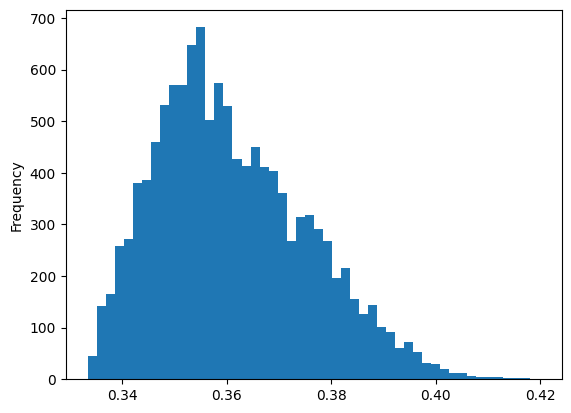

In [17]:
tweets_sent_df["score"].plot(kind="hist", bins=50)

### Plots

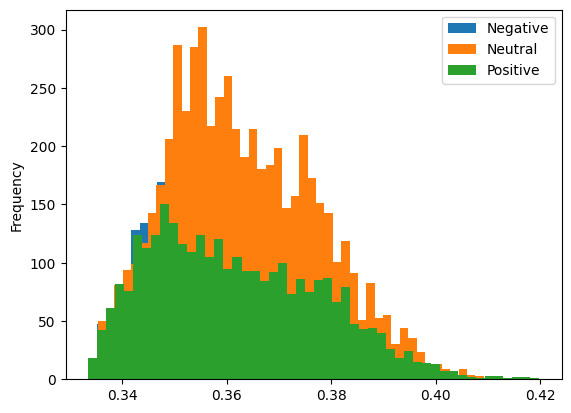

In [21]:
tweets_sent_df.groupby("label")["score"].plot(kind="hist", bins=50)
plt.legend()
plt.show()

In [29]:
tweets_sent_df["score_"] = tweets_sent_df["score"]

tweets_sent_df.loc[tweets_sent_df["label"] == "Negative", "score_"] = (
    tweets_sent_df.loc[tweets_sent_df["label"] == "Negative"]["score"] * -1
)

# Here making the neutral 0
tweets_sent_df.loc[tweets_sent_df["label"] == "Neutral", "score_"] = 0

label
Negative    AxesSubplot(0.125,0.11;0.775x0.77)
Neutral     AxesSubplot(0.125,0.11;0.775x0.77)
Positive    AxesSubplot(0.125,0.11;0.775x0.77)
Name: score_, dtype: object

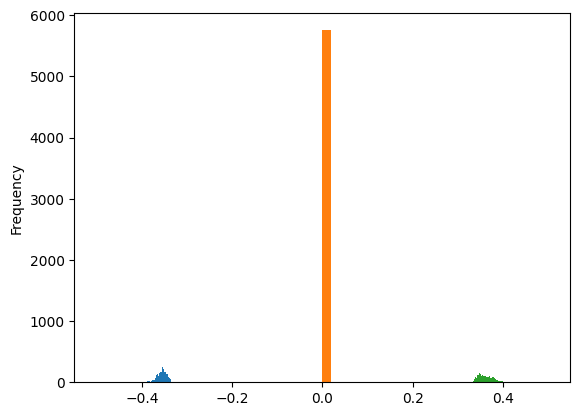

In [30]:
tweets_sent_df.groupby("label")["score_"].plot(kind="hist", bins=50)

In [26]:
tweets_sent_df["Date"] = tweets_sent_df["Datetime"].dt.date

<AxesSubplot: xlabel='Date'>

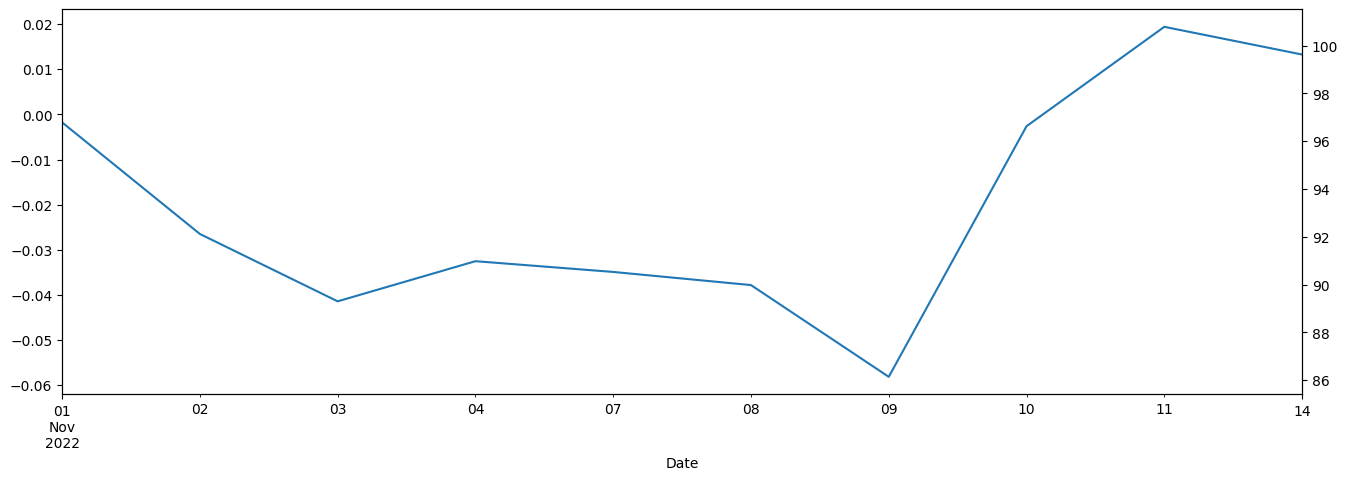

In [65]:
# fig, ax = plt.subplots(figsize=(16, 5))

ax = tweets_sent_df.groupby("Date")["score_"].mean().plot(figsize=(16, 5))
ax2 = ax.twinx()
hists["AMZN"]["Close"].tail(10).plot(ax=ax2)

In [40]:
daily_sentiment = tweets_sent_df.groupby("Date")["score_"].mean()

In [41]:
daily_sentiment

Date
2022-11-06   -0.058145
2022-11-07   -0.007492
2022-11-08   -0.037072
2022-11-09    0.006408
2022-11-10    0.019398
2022-11-11   -0.004475
Name: score_, dtype: float64

In [53]:
amzn_df = hists["AMZN"].copy()
amzn_df = amzn_df.reset_index()
amzn_df["Date"] = amzn_df["Date"].dt.date
amzn_df.set_index("Date", inplace=True)

In [49]:
amzn_df

Date       Open        High        Low       Close     Volume  \
0    2019-11-14  87.571503   88.329498  87.477997   87.730003   45296000   
1    2019-11-15  88.002502   88.084000  86.642998   86.974503   78552000   
2    2019-11-18  86.915001   87.684998  86.135498   87.626503   56790000   
3    2019-11-19  87.849503   88.033997  87.151497   87.639503   45416000   
4    2019-11-20  87.457001   88.125999  86.706001   87.276497   55800000   
..          ...        ...         ...        ...         ...        ...   
751  2022-11-08  90.790001   91.720001  88.230003   89.980003   88703400   
752  2022-11-09  89.470001   89.480003  85.870003   86.139999   90796200   
753  2022-11-10  92.940002   98.690002  91.650002   96.629997  173414900   
754  2022-11-11  97.879997  101.190002  96.660004  100.790001  111481700   
755  2022-11-14  98.769997  100.119904  97.309998   99.629997   66025619   

     Dividends  Stock Splits  
0            0           0.0  
1            0           0.0  
2            0           0.0  
3            0           0.0  
4            0           0.0  
..         ...           ...  
751          0           0.0  
752          0           0.0  
753          0           0.0  
754          0           0.0  
755          0           0.0  

[756 rows x 8 columns]

In [55]:
daily_sentiment.to_frame("sentiment")

sentiment
Date                 
2022-11-06  -0.058145
2022-11-07  -0.007492
2022-11-08  -0.037072
2022-11-09   0.006408
2022-11-10   0.019398
2022-11-11  -0.004475

## Merge sentiment and stock and results

In [59]:
# daily_sentiment.to_frame("sentiment").merge(amzn_df, left_index=True, right_index=True)
stock_and_sent = daily_sentiment.to_frame("sentiment").merge(
    amzn_df, how="inner", on=["Date", "Date"]
)

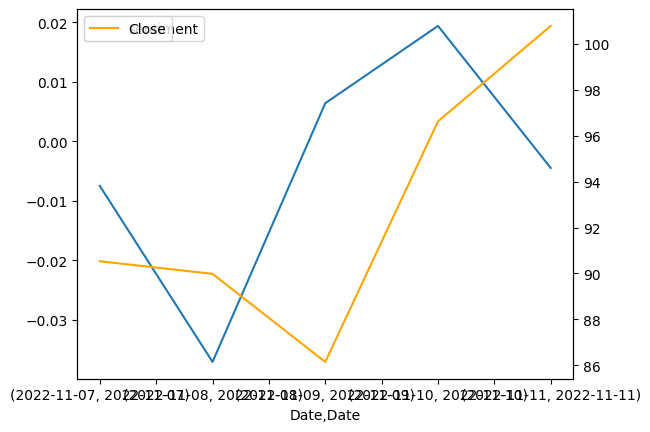

In [68]:
ax = stock_and_sent["sentiment"].plot(legend="sentiment")
ax2 = ax.twinx()
stock_and_sent["Close"].plot(ax=ax2, color="orange", legend="close")
plt.show()